# Getting started with dask-sql, Dask, and Coiled

Lots of people talk about "democratizing" data (and ML/AI, etc.) and what could be more democratic -- in the sense of widely accessible -- than SQL & PyData? (except maybe Microsoft Excel 😀)

In this notebook, we look at `dask-sql`, an exciting new open-source library that offers a SQL front-end to Dask. Follow along on Coiled Cloud with this notebook. [Maybe add a "tile" to the Coiled launcher for this? Otherwise add a link. You may want to host it on coiled.io rather than in my personal S3 bucket]

### Launch a cluster

`dask-sql` is free + open source and will work with any Dask cluster, so you can run this (with minimal modification) on any environment. That said, the easiest way to spin up a cluster in the cloud is with Coiled [insert additional marketing verbage here]

If you haven't signed up for the Coiled beta, you can do so for free with just a Github or Google ID at https://coiled.io

In [3]:
import coiled
from dask.distributed import Client

cluster = coiled.Cluster(n_workers=20)
client = Client(cluster)

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1130: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+---------+
| Package     | client | scheduler | workers |
+-------------+--------+-----------+---------+
| blosc       | None   | 1.9.2     | 1.9.2   |
| dask        | 2.28.0 | 2.29.0    | 2.29.0  |
| distributed | 2.28.0 | 2.29.0    | 2.29.0  |
| lz4         | None   | 3.1.0     | 3.1.0   |
+-------------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [4]:
client

Client Scheduler: tls://ec2-3-21-129-247.us-east-2.compute.amazonaws.com:8786 Dashboard: https://cloud.coiled.io/dashboard/1860/status,Cluster Workers: 10 Cores: 40 Memory: 171.80 GB


Next, we'll install `dask-sql`. It's a simple install but may take a minute or two.

In [ ]:
#! conda install -y dask-sql -c conda-forge

### Analyze data in the cloud

At this point, we're ready to start querying data!

Before we run our first SQL query, let's test things out with a variant of the "starter" query from Coiled Cloud's Quickstart notebook. 
    
* This query calculates average tip amount by passenger count for the 2019 records in the NYC taxicab dataset.

Then we'll try it again in SQL.

In [24]:
import dask.dataframe as dd

df = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv",
    dtype={
        "payment_type": "UInt8",
        "VendorID": "UInt8",
        "passenger_count": "UInt8",
        "RatecodeID": "UInt8",
    },
    storage_options={"anon": True}
)


df.groupby("passenger_count").tip_amount.mean().compute()

passenger_count
0    2.122789
1    2.206790
2    2.214306
3    2.137775
4    2.023804
5    2.235441
6    2.221105
7    6.675962
8    7.111625
9    7.377822
Name: tip_amount, dtype: float64

Great!

Our cluster and code are running. 

### Now let's try some SQL!

`dask-sql` uses some code to "automagically" locate the JVM shared library we'll need, but it doesn't find the right path here in this cloud-deployed Jupyter container. We'll give it a hint:

In [6]:
import os
os.environ["JAVA_HOME"] = "/opt/conda/lib/server"

> __Wait! What?! Java!?__
>
> What's going on here?
> 
> Dask-sql uses a well-established Java library, Apache Calcite, to parse the SQL and perform some initial work on your query. More on this later. It's a good thing, because it means that dask-sql isn't reinventing yet another query parser and optimizer, although it does create a dependency on the JVM.

In [7]:
from dask_sql import Context

c = Context()

This `Context` instance will let us run queries ... but first we need some data sources.

There are a number of ways to define data sources with `dask-sql` but one of the simplest is to supply a Dask Dataframe as the source. The Dask Dataframe
* is lazy, so it doesn't retrieve the data until needed
* can discover the data schema
* supports out-of-core access -- a fancy way of saying it *does not* need to actually load the data up into memory (e.g., maybe the data doesn't fit in memory, or maybe you want that memory for other computations)
* knows how to retrieve the data from the underlying source (e.g., "CSV files in S3")

Here's the dataframe we defined above:

In [8]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
npartitions=127,,,,,,,,,,,,,,,,,,
,UInt8,object,object,UInt8,float64,UInt8,object,int64,int64,UInt8,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We can assign a table name to this dataframe, and then use that table name within SQL queries.

The following code
1. associates the table name `taxi` with `df`
2. creates a query to count the rows in this table
3. returns a handle to a *lazy resultset in the form of a Dask dataframe*

In [9]:
c.register_dask_table(df, "taxi")

result = c.sql('SELECT count(1) FROM taxi')

result

,COUNT(1)
npartitions=1,
,int64
,...


In almost all cases, running `c.sql(...)` will *not* actually run the full query, but just produces a Dask dataframe handle representing the results. (There are a couple of edge cases in the dask-sql docs that do trigger an immediate computation today, but the long term goal is to make as much lazy as possible.)

How do we get our actual rowcount out? The same way we evaluate any other small Dask result that we want to retrieve: via `.compute()`

In [10]:
result.compute()

,COUNT(1)
0,84399019


Ok, we've run our first `dask-sql` query and gotten results back!

### Speed Test

Now let's revisit the "starter query" -- the one that calculates average tip amount by passenger count. 

We have two goals here:
* Write the same query in Dask/Python and in SQL, and see that they work and product the same results
* Time the execution, to verify that SQL does not add any significant performance overhead
    * The SQL query gets processed and converted for Dask just once no matter how much data is involved, so it should not add any cost for nontrivial datasets
    
> If you're trying this out, this is also a great time to view the Dask task stream dashboard, to see the cluster in action. You can do this via the JupyterLab extension or through the Coiled Cloud GUI.

In [26]:
%%time

df.groupby("passenger_count").tip_amount.mean().compute()

CPU times: user 107 ms, sys: 1.18 ms, total: 108 ms
Wall time: 26.7 s


passenger_count
0    2.122789
1    2.206790
2    2.214306
3    2.137775
4    2.023804
5    2.235441
6    2.221105
7    6.675962
8    7.111625
9    7.377822
Name: tip_amount, dtype: float64

In [27]:
%%time

c.sql('SELECT avg(tip_amount) FROM taxi GROUP BY passenger_count').compute()

CPU times: user 267 ms, sys: 8.7 ms, total: 276 ms
Wall time: 24.7 s


,"AVG(""taxi"".""tip_amount"")"
0,2.122789
1,2.206790
2,2.214306
3,2.137775
4,2.023804
5,2.235441
6,2.221105
7,6.675962
8,7.111625
9,7.377822


#### What is the takeaway?

You should see identical output. Moreover, you should see near identical wall-clock time. The SQL processing adds 100ms or less, and is a constant, one-time cost.

## SQL + Cached data = turbocharged analytics

Let's see how we can accelerate analytics by caching this dataset in our cluster, and then running SQL queries against that cached data.

This isn't just fast, it's whole-team-friendly because 
* we can expose this dataset to other Dask analysts, incentivizing sharing a "large RAM pool" cluster for analytics over the data
* `dask-sql` exposes the __Presto__ wire protocol, so folks using Presto compatible clients or visualization tools can access this data with zero programming!

First, we'll ask Dask to cache the table...

In [13]:
dfp = df.persist()

It may take a few seconds (or a lot more for really big datasets) to get loaded into cluster RAM. 

We can watch blocks load up in realtime in the Dask Graph dashboard. This shows tasks turn green as they compute and then red as the results are loaded in memory. In this case, each task retrieves a partition of the data from S3.

In other situations, we may not want to watch a GUI, but programmatically wait for the data to be loaded. 

We can do that using `distributed.wait(...)`:

In [14]:
import distributed

In [15]:
cached_tasks = distributed.wait(dfp)
print(f'cached {len(cached_tasks[0])} results')

cached 127 results


Next, we'll give a new table name to this new cached flavor of the dataset (the `dfp` to which we assigned the result of `df.persist` above).

`dfp` is a little opaque, so we'll name this table `taxi_cached`

In [16]:
c.register_dask_table(dfp, "taxi_cached")

As a quick test to see how much faster it is working out of memory, let's count the rows again.

In [17]:
result = c.sql('SELECT count(1) FROM taxi_cached')
result.compute()

,COUNT(1)
0,84399019


Let's also try that average tip by passenger count query, this time from cache.

In [18]:
%%time

c.sql('SELECT avg(tip_amount) FROM taxi_cached GROUP BY passenger_count').compute()

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 1.77 s


,"AVG(""taxi_cached"".""tip_amount"")"
0,2.122789
1,2.206790
2,2.214306
3,2.137775
4,2.023804
5,2.235441
6,2.221105
7,6.675962
8,7.111625
9,7.377822


Not surprisingly, since working from the cached data removes most of the I/O, parsing, and ser/de from the job, it runs a lot faster than before.

### SQL built-in functions

`dask-sql` also exposes a number of helper functions in SQL -- just like traditional relational databases expose helper functions for math, date/time processing, string manipulation, and more.

Here's the `floor` function running on a static literal value:

In [19]:
c.sql('SELECT floor(3.14)').compute()

,FLOOR(3.14)
0,3.0


Using `floor` to discretize (or bin) the trip distances, we can look at a coarse-grained average fare for distance buckets.

Our next query looks at rides with distances between 0 and 50, splits (`GROUP BY`) the binned (`floor()`) distance, and then for each of those bins, returns the `floor`'ed distance, the average fare, and the number of rides.

*Since we know -- based on our query -- that the report output will contain just 50 rows and 3 columns, we can safely `compute` it and get a result locally as a regular Pandas dataframe. If our result were much larger -- or an intermediate transformation that we want to use in subsequent operations -- we would either write it to persistent storage, or keep the result in the cluster. After all, a big dataset will not fit in our local process, where the Dask `Client` and `dask-sql` `Context` objects live.*

In [20]:
%%time

c.sql("""
    SELECT floor(trip_distance) AS dist, avg(fare_amount) as fare, count(1) as trip_count
    FROM taxi_cached 
    WHERE trip_distance < 50 AND trip_distance >= 0 
    GROUP BY floor(trip_distance)
""").compute()

CPU times: user 710 ms, sys: 8.94 ms, total: 719 ms
Wall time: 3.19 s


,dist,fare,trip_count
0,0.0,6.599070,21452505
1,1.0,8.637107,28339607
2,2.0,12.212198,12901257
3,3.0,15.443046,6082367
4,4.0,18.258702,3302215
5,5.0,20.853578,2180951
6,6.0,23.368139,1537720
7,7.0,26.443811,1186792
8,8.0,28.761726,1114168
9,9.0,31.517287,1030230


> __Opportunity to contribute__
>
> If you look at the `dask-sql` docs, you'll notice that there aren't that many helper functions implemented yet. For example, most databases have several string-processing helper functions, and today `dask-sql` just has one.
>
> This is a great opportunity to add valuable functionality and contribute to the library, since implementing many of these functions is just a matter of finding the existing Dask function and hooking it up. 
>
> There are a ton of functions we might want to add, but each one is small, so it's a great crowd-sourcing opportunity. You can see the existing implementations in https://github.com/nils-braun/dask-sql/blob/main/dask_sql/physical/rex/core/call.py


### One more example: fast plotting from big data

Since our results come back fast and as a Pandas dataframe, we can easily make visualizations. This pattern can help us approach near-real-time interactive data exploration and visualization.

If you don't have `matplotlib` installed (e.g., today it's not built in to the Coiled quickstart notebook image) you can install it with this command:

In [ ]:
# ! conda install -y matplotlib -c conda-forge

And now we can run a query and immediately plot a visualization of the result using Pandas plotting syntax!

<AxesSubplot:xlabel='dist'>

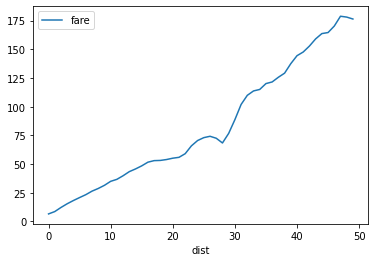

In [21]:
c.sql("""
    SELECT floor(trip_distance) AS dist, avg(fare_amount) as fare
    FROM taxi_cached 
    WHERE trip_distance < 50 AND trip_distance >= 0 
    GROUP BY floor(trip_distance)
""").compute().plot(x='dist', y='fare')

## A Peek Under the Hood

### How does the technology fit together?

`dask-sql` relies on the well-established Apache Calcite (https://calcite.apache.org/), a Java project, to
* parse SQL
* represent queries as a tree of operators
* normalize and optimize queries
    * Calcite's optimizer is extensible, so there are numerous "plug points" for adding more capabilities in the future

That's a lot! What's left?

The output from Calcite is a representation of a query as a tree of logical operators. These are things like __projections__ (think of them as abstractions of `SELECT`s) and __filters__ (abstractions of `WHERE`).

The next job of `dask-sql` is to provide plugins that convert from purely abstract operators to logic that expresses that operation in terms of Dask APIs. The results are still logical operators, but a bit more concrete -- similar to what you would get if you wrote a Dask dataframe query yourself, so it's ready to execute on your Dask cluster. At execution time, Dask provides physical implementations of the operations, which vary depending, e.g., on how your data is stored.

## Creating more opportunities

Synergy is a cliche these days. But adding a SQL front-end to Dask enables a ton of new users and new uses cases to share state-of-the-art Python data solutions.

For example, analysts and businesspeople who are fluent with SQL but don't write imperative code can now leverage Dask, PyData, Coiled, and so much more ... while collaborating with those who do prefer to code.

Custom function support in `dask-sql` means coders can create simple wrappers around complex flows (e.g., applying a machine learning model to score records) and SQL users can create reports with those functions.

Last, with database server capability via Presto (and perhaps soon JDBC, since Calcite includes JDBC support) it becomes possible to take a visualization solution like Tableau and point it at a Dask cluster for visual analytics at scale.

##### Links:
* Dask, Coiled and PyData https://coiled.io/blog/pydata-dask/
* Dask SQL docs https://dask-sql.readthedocs.io/
* Dask SQL source https://github.com/nils-braun/dask-sql
* Apache Calcite https://calcite.apache.org/